## Library Imports

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float

In [3]:
class CsvLogger:
    """
    A quick-and-simple CSV logger that appends
    rows to a specified file on disk.
    """

    def __init__(self, file_name):
        self.file_name = file_name

        with open(f"{self.file_name}.csv", "w") as f:
            # Create/empty the file initially
            pass

    def write_entry(self, text_line):
        with open(f"{self.file_name}.csv", "a") as f:
            f.write(f"{text_line}\n")


##############################################
# Environment Runner
##############################################
class EnvironmentRunner:
    """
    Manages interactions with an OpenAI Gym environment:
    - Resets the environment
    - Steps through it given an agent's actions
    - Logs returns and gathers trajectory data
    """

    def __init__(self, gym_env):
        self.gym_env = gym_env
        self.num_actions = self.gym_env.action_space.n

        self.logger = CsvLogger("episode_returns")
        self.logger.write_entry("training_step,return")

        self.observation = self.gym_env.reset()
        self.episodes_count = 0


    def run(self, agent, show_render=False):
            """
            Runs one full episode:
            1) Resets environment
            2) Steps until done
            3) Logs returns
            4) Returns the collected trajectory
            """
            obs_list = []
            actions_list = []
            rewards_list = []
            done_list = []
            policy_list = []
            values_list = []

            # initial reset
            self.observation = self.gym_env.reset()
            obs_list.append(torch.tensor(self.observation))

            finished = False
            while not finished:
                # Let agent infer the next action
                chosen_action, distribution, val_est = agent.inference(
                    torch.tensor(self.observation, dtype=dtype, device=device)
                )

                next_obs, reward, finished, info = self.gym_env.step(chosen_action)

                # Store
                obs_list.append(torch.tensor(next_obs))
                actions_list.append(chosen_action)
                policy_list.append(torch.tensor(distribution))
                values_list.append(val_est)
                rewards_list.append(torch.tensor(reward))
                done_list.append(finished)

                # Check if episode ended
                if finished:
                    if "return" in info:
                        # Log it
                        self.logger.write_entry(f"{self.episodes_count},{info['return']}")

                # Optional render
                if show_render:
                    self.gym_env.render()
                    time.sleep(0.024)

                self.observation = next_obs

            self.episodes_count += 1
            return self.build_trajectory(obs_list, actions_list, rewards_list, done_list, policy_list, values_list)

    @staticmethod
    def build_trajectory(obs, acts, rews, finished_flags, pols, vals):
        return {
            "obs": obs,
            "actions": acts,
            "rewards": rews,
            "dones": finished_flags,
            "pis": pols,
            "vs": vals,
            "length": len(obs)
        }
        
class LoggingEnvRunner(EnvironmentRunner):
    """
    Extends EnvironmentRunner to log episode returns.
    """
    def __init__(self, env):
        super().__init__(env)
        self.episode_returns = []

    def run(self, agent):
        trajectory = super().run(agent)  # normal run
        # Summation of the episode's rewards:
        ep_return = float(np.sum(trajectory["rewards"]))
        self.episode_returns.append(ep_return)
        return trajectory

In [4]:
##############################################
# A simple Gym Wrapper
##############################################
class GymWrapper(gym.Wrapper):
    """
    A wrapper that folds multiple historical observations
    into a single stacked observation.
    """

    def __init__(self, env, history_len):
        super().__init__(env)
        self.history_len = history_len
        self.obs_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n

    def reset(self):
        self.episode_return = 0
        self.observations_rollout = []

        obs = self.env.reset()
        self.observations_rollout.append(obs)

        return self.aggregate()

    def aggregate(self):
        """
        Stacks the last N observations (with possible zero-padding).
        Returns them as a flattened array of shape (1, -1).
        """
        stacked = np.zeros((self.history_len, self.obs_dim))

        current_length = len(self.observations_rollout)
        if current_length == self.history_len:
            stacked = np.array(self.observations_rollout)
        else:
            stacked[self.history_len - current_length :] = np.array(
                self.observations_rollout
            )

        return stacked.flatten().reshape(1, -1)

    def step(self, action):
        next_obs, reward, done, info = self.env.step(action)
        self.update_history(next_obs)
        aggregated_obs = self.aggregate()

        self.episode_return += reward
        if done:
            info["return"] = self.episode_return

        return aggregated_obs, reward, done, info

    def update_history(self, new_obs):
        if len(self.observations_rollout) == self.history_len:
            # drop oldest
            self.observations_rollout = self.observations_rollout[1:]
        self.observations_rollout.append(new_obs)

In [5]:
##############################################
# Buffer Replay (Experience)
##############################################
class BufferReplay:
    """
    Stores entire episodes (trajectories), then allows sampling
    sub-portions for training (k-step unroll & n-step return).
    """

    def __init__(self, capacity, num_actions):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.num_actions = num_actions

    def add_trajectories(self, new_trajectories):
        """
        Insert new trajectories (episodes) into the memory buffer.
        Overwrites older ones if the capacity is reached.
        """
        for traj in new_trajectories:
            if len(self.memory) < self.capacity:
                self.memory.append(None)
            self.memory[self.position] = traj
            self.position = (self.position + 1) % self.capacity

    def sample_sub_trajectory(self, k, n, discount):
        """
        Randomly picks a single stored trajectory, picks a start index,
        returns the k-step unroll data plus n-step returns.
        """
        data = {
            "obs": None,
            "pi": [],
            "v": [],
            "actions": [],
            "rewards": [],
            "return": [],
        }

        # Choose a random trajectory
        mem_idx = np.random.choice(len(self.memory), 1)[0]
        chosen_length = self.memory[mem_idx]["length"]
        last_idx = chosen_length - 1

        # Random start
        start = np.random.choice(chosen_length, 1)[0]

        # We'll record the initial observation
        data["obs"] = self.memory[mem_idx]["obs"][start]

        # Collect data for each unroll step
        for step in range(start, start + k + 1):
            lookahead = step + n

            # If looking beyond trajectory end, v_n = 0
            if lookahead >= last_idx:
                future_value = torch.tensor(
                    [0.0], device=device, dtype=dtype
                )
            else:
                future_value = self.memory[mem_idx]["vs"][lookahead] * (discount**n)

            # sum of discounted rewards up to n or end
            total_val = future_value.clone()
            max_reward_idx = min(last_idx, lookahead)
            enumer_rewards = list(
                enumerate(self.memory[mem_idx]["rewards"][step:max_reward_idx])
            )
            for i, single_r in enumer_rewards:
                total_val += single_r * (discount**i)

            data["return"].append(total_val)

            # Not storing reward for the very initial step in the unroll
            if step != start:
                if 0 < step <= last_idx:
                    data["rewards"].append(self.memory[mem_idx]["rewards"][step - 1])
                else:
                    data["rewards"].append(torch.tensor([0.0], device=device))

            # Pi distribution
            if 0 <= step < last_idx:
                data["pi"].append(self.memory[mem_idx]["pis"][step])
            else:
                # In case we are beyond the real trajectory
                uniform_probs = np.ones(self.num_actions) / self.num_actions
                data["pi"].append(torch.tensor(uniform_probs, dtype=dtype))

        # Build the real set of actions from the actual trajectory
        max_valid_step = min(last_idx - 1, start + k - 1)
        num_steps_valid = max_valid_step - start
        data["actions"] = self.memory[mem_idx]["actions"][
            start : start + num_steps_valid + 1
        ]

        # Fill with random actions if we unroll beyond the stored trajectory
        fill_count = k - num_steps_valid + 1
        for _ in range(fill_count):
            rand_act = np.random.choice(self.num_actions, 1)[0]
            data["actions"].append(rand_act)

        return data

    def sample_batch(self, batch_size, k, n, discount=0.99):
        """
        Returns a batch (list) of sub trajectories. Each item
        in the batch has the keys: obs, pi, v, actions, rewards, return
        """
        batch_data = []
        for _ in range(batch_size):
            sample = self.sample_sub_trajectory(k, n, discount)
            batch_data.append(sample)
        return batch_data

    def __len__(self):
        return len(self.memory)


In [6]:
##############################################
# Representation, Dynamics, Prediction models
##############################################
class RepresentationNet(nn.Module):
    """
    Maps an environment observation into a hidden state.
    """

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        layers = [
            nn.Linear(self.input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, self.hidden_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class DynamicsNet(nn.Module):
    """
    Predicts the next hidden state and immediate reward
    from current hidden state and action encoding.
    """

    def __init__(self, hidden_dim, action_space):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_actions = action_space

        net_layers = [
            nn.Linear(self.hidden_dim + 1, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, self.hidden_dim + 1),  # last dimension is reward
        ]
        self.model = nn.Sequential(*net_layers)

    def forward(self, x):
        out = self.model(x)
        next_state, reward_est = out[:, : self.hidden_dim], out[:, -1]
        return next_state, reward_est


class PredictionNet(nn.Module):
    """
    Given a hidden state, outputs:
      - A policy distribution (num_actions)
      - A scalar value estimate
    """

    def __init__(self, hidden_dim, num_actions):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_actions = num_actions

        net_blocks = [
            nn.Linear(self.hidden_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, self.num_actions + 1),  # final: [policy_logits, value]
        ]
        self.model = nn.Sequential(*net_blocks)

    def forward(self, hidden_x):
        raw_output = self.model(hidden_x)
        raw_policy = raw_output[:, : self.num_actions]
        raw_value = raw_output[:, -1]

        # Softmax for policy
        policy = F.softmax(raw_policy, dim=1)
        return policy, raw_value


In [7]:
##############################################
# MCTS Support Classes
##############################################
class AdaptiveNormalizer:
    """
    Simple min-max normalizer that tracks running min/max
    so we can scale Q-values in MCTS.
    """

    def __init__(self):
        self.max_val = float("-inf")
        self.min_val = float("inf")

    def update(self, val):
        val_cpu = val.cpu()
        self.max_val = max(self.max_val, val_cpu)
        self.min_val = min(self.min_val, val_cpu)

    def normalize(self, val):
        val_cpu = val.cpu()
        if self.max_val > self.min_val:
            return ((val_cpu - self.min_val) / (self.max_val - self.min_val)).to(
                device
            )
        return val_cpu
    
    
class TreeNode:
    """
    Node for MCTS: stores children edges, prior,
    aggregated value stats, and so on.
    """

    def __init__(self, prior_prob):
        self.prior_prob = prior_prob
        self.state_rep = None
        self.reward_est = None
        self.edges = {}  # action -> TreeNode

        self.total_value_sum = 0.0
        self.visit_count = 0

    def is_expanded(self):
        return len(self.edges) > 0

    def avg_value(self):
        if self.visit_count == 0:
            return 0.0
        return self.total_value_sum / self.visit_count
    
    
    
##############################################
# Some utility function
##############################################
def minmax_normalize_state(s):
    """
    Simple bounding of the input tensor to [0,1] range per row.
    Not guaranteed to be safe for all tasks, but included for example.
    """
    b_size = s.shape[0]
    s_min = torch.min(s, dim=1)[0].reshape(b_size, 1)
    s_max = torch.max(s, dim=1)[0].reshape(b_size, 1)
    return (s - s_min) / (s_max - s_min)



class MCTS:
    """
    Runs MCTS simulations to select actions.
    Has:
      - root exploration noise
      - expansions
      - backup of value
      - UCB calculation
    """

    def __init__(
        self,
        num_actions,
        dyn_net,
        pred_net,
        controlling_agent,
        gamma=0.99,
    ):
        self.num_actions = num_actions
        self.c1 = 1.25
        self.c2 = 19652
        self.gamma = gamma

        self.root_dirichlet_alpha = 0.25
        self.root_exploration_fraction = 0.25

        self.dyn_net = dyn_net
        self.pred_model = pred_net
        self.agent = controlling_agent
        self.value_tracker = None  # Assigned new for each search

    def run(self, sims_count, root_state):
        # Create the root
        init_policy, init_value = self.pred_model(root_state)
        init_policy, init_val = init_policy.detach(), init_value.detach()
        self.root_node = self._initialize_root(root_state, init_policy)

        # track min/max for value normalization
        self.value_tracker = AdaptiveNormalizer()

        # Perform MCTS simulations
        for _ in range(sims_count):
            self.search_path = []
            self.search_path.append(self.root_node)
            self.action_path = []

            current_node = self.root_node
            while current_node.is_expanded():
                act_chosen, next_node = self._select_ucb_action(current_node)
                self.search_path.append(next_node)
                self.action_path.append(act_chosen)
                current_node = next_node

            # Expand the newly reached leaf
            leaf_parent = self.search_path[-2]
            new_value = self._expand_node(
                leaf_parent, current_node, self.action_path[-1]
            )

            # Backup
            self._backpropagate(new_value)

        # Return (visit distribution, root value)
        visit_counts = self._compute_pi()
        return visit_counts, self.root_node.avg_value()

    def _expand_node(self, parent_node, new_node, chosen_action):
        next_s, new_pi, new_v, new_reward = self.agent.rollout_step(
            parent_node.state_rep, [chosen_action]
        )
        next_s = next_s.detach()
        new_pi = new_pi.detach()
        new_v = new_v.detach()
        new_reward = new_reward.detach()

        new_node.state_rep = next_s
        new_node.reward_est = new_reward

        # create children edges
        for a in range(self.num_actions):
            new_node.edges[a] = TreeNode(new_pi[0, a])

        return new_v

    def _backpropagate(self, leaf_value):
        """
        Moves up the search path, updating each node's total_value_sum and visits
        with the discounted sum of rewards + leaf_value.
        """
        for node in reversed(self.search_path):
            node.total_value_sum += leaf_value
            node.visit_count += 1

            # Update normalizer with (reward + gamma * node_value)
            self.value_tracker.update(node.reward_est + self.gamma * node.avg_value())

            leaf_value = node.reward_est + self.gamma * leaf_value

    def _select_ucb_action(self, node):
        # Evaluate UCB for each child
        ucb_scores = [
            self._calc_ucb(node, node.edges[a]) for a in range(self.num_actions)
        ]
        best_act = np.argmax(ucb_scores)
        return best_act, node.edges[best_act]

    def _calc_ucb(self, parent, child):
        # PUCT formula
        pb_c = math.log((parent.visit_count + self.c2 + 1.0) / self.c2) + self.c1
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1.0)

        prior_val = pb_c * child.prior_prob

        if child.visit_count > 0:
            val_score = self.value_tracker.normalize(
                child.reward_est + self.gamma * child.avg_value()
            )
        else:
            val_score = 0.0
        return (prior_val + val_score).item()

    def _compute_pi(self):
        # For each possible action from root, gather visits
        visits = []
        for a in range(self.num_actions):
            visits.append(self.root_node.edges[a].visit_count)
        return np.array(visits)

    def _add_root_noise(self, root):
        noise = np.random.dirichlet([self.root_dirichlet_alpha] * self.num_actions)
        frac = self.root_exploration_fraction
        for act_id, n_val in zip(range(self.num_actions), noise):
            root.edges[act_id].prior_prob = (
                root.edges[act_id].prior_prob * (1 - frac) + n_val * frac
            )
        return root

    def _initialize_root(self, root_tensor, p_init):
        p_init = p_init.detach().cpu().numpy()
        node = TreeNode(0)
        node.state_rep = root_tensor
        node.reward_est = 0

        for i in range(self.num_actions):
            node.edges[i] = TreeNode(p_init[0, i])

        # Add exploration noise
        node = self._add_root_noise(node)
        return node
    
    
def naive_depth_search(agent, state, num_actions, gamma_val, search_depth=3):
    """
    Very naive search that fully expands all actions up to a given depth,
    tracks predicted reward + discounted value at the leaf, picks best.
    """
    possible_acts = np.arange(num_actions)
    
    # Just get the root value
    _, root_v = agent.pred_net(state)
    root_value = None

    combined_rewards = torch.tensor([0.0], device=device)
    
    for depth in range(search_depth):
        state = torch.repeat_interleave(state, num_actions, dim=0)
        repeated_acts = np.repeat([possible_acts], num_actions**depth, axis=0).flatten()
        
        # Roll out one step
        next_s, _, leaf_val, leaf_r = agent.rollout_step(state, repeated_acts)
        state = next_s.detach()
        leaf_val = leaf_val.detach()
        leaf_r = leaf_r.detach()

        # Expand reward sum
        combined_rewards = torch.repeat_interleave(combined_rewards, num_actions, dim=0)
        adjusted_r = leaf_r * (gamma_val**depth)
        combined_rewards += adjusted_r

    # discount leaf value
    final_vals = leaf_val.cpu().numpy() * (gamma_val**search_depth)
    # total
    final_vals += combined_rewards.cpu().numpy()

    # pick best
    best_index = np.argmax(final_vals)
    possible_branches = num_actions ** (search_depth - 1)
    chosen_act = int(best_index / possible_branches)

    return chosen_act, root_v


In [8]:
##############################################
# Agent
##############################################
class Agent(nn.Module):
    """
    Agent with optional MCTS or naive search to pick actions.
    """

    def __init__(
        self,
        sim_count,
        num_actions,
        rep_net,
        dyn_net,
        pred_net,
        search_type="mcts",
        disc_factor=0.99,
        naive_len=3,
        epsilon=0.1,
    ):
        super().__init__()
        self.rep_net = rep_net
        self.dyn_net = dyn_net
        self.pred_net = pred_net

        self.num_actions = num_actions
        self.gamma = disc_factor
        self.search_type = search_type
        self.simulations = sim_count
        self.naive_search_depth = naive_len
        self.temperature = 1.0
        self.epsilon = epsilon

        if self.search_type == "mcts":
            self.mcts = MCTS(
                num_actions, dyn_net, pred_net, self, gamma=disc_factor
            )
        else:
            self.mcts = None

    def forward(self, obs):
        pass

    def inference(self, obs_tensor):
        """
        Returns:
          (action_int, policy_distribution, estimated_value)
        """
        # convert observation to hidden
        hidden = self.rep_net(obs_tensor)

        if self.mcts:
            # MCTS-based
            child_visits, root_val = self.mcts.run(self.simulations, hidden)
            action_probs = child_visits / np.sum(child_visits)

            # Apply temperature
            adjusted_pi = (child_visits ** (1 / self.temperature)) / np.sum(
                child_visits ** (1 / self.temperature)
            )
            action = np.random.choice(self.num_actions, p=adjusted_pi)
            return action, action_probs, root_val
        elif self.search_type == "naive":
            # naive search
            best_a, r_val = naive_depth_search(
                self, hidden, self.num_actions, self.gamma, self.naive_search_depth
            )
            
            greedy = torch.rand(1)

            if greedy < self.epsilon:
                # Explore: choose a random action
                action = np.random.choice(self.num_actions)
            else:
                # Exploit: choose the best action
                action = best_a
            result_pi = np.zeros(self.num_actions, dtype=np.float32)
            result_pi[action] = 1.0
            return action, result_pi, r_val
        else:
            # direct prediction
            with torch.no_grad():
                pol, val = self.pred_net(hidden)
            # sample from pol^1/T or argmax
            pol_np = pol[0].cpu().numpy()
            pol_np = pol_np ** (1.0 / self.temperature)
            pol_np = pol_np / pol_np.sum()
            action = np.random.choice(self.num_actions, p=pol_np)
            return action, pol_np, val

    def initial_step(self, obs):
        """
        The initial representation + prediction for the root.
        """
        s = self.rep_net(obs)
        pol, v = self.pred_net(s)
        return s, pol, v

    def rollout_step(self, hidden_s, chosen_actions):
        """
        Takes in hidden states and actions, uses the dynamics net
        to get next hidden states + rewards, then the prediction net
        for policy + value.
        """
        batch_sz = hidden_s.shape[0]
        # Normalize action to [0,1]
        act_enc = torch.tensor(
            chosen_actions, dtype=dtype, device=device
        ).reshape(batch_sz, 1)
        act_enc /= self.num_actions

        # feed dynamics
        dyn_input = torch.cat([hidden_s, act_enc], dim=1)
        next_hidden, predicted_reward = self.dyn_net(dyn_input)

        # get next policy + value
        p, v = self.pred_net(next_hidden)

        return next_hidden, p, v, predicted_reward


In [9]:
def train_with_search_policy(search_type):
    """
    Trains a MuZero_Agent with the given `search_type` using
    your exact train-loop code. We only add reward logging/plotting.
    """
    # Your same hyper-params:
    history_length = 4
    num_hidden = 50
    num_simulations = 40
    replay_capacity = 200
    batch_size = 64
    k = 7
    n = 15
    lr = 1e-3
    value_coef = 1
    reward_coef = 1

    # Environment
    raw_env = gym.make('CartPole-v0')
    num_obs_space = raw_env.observation_space.shape[0]
    num_actions = raw_env.action_space.n
    num_in = history_length * num_obs_space
    env = GymWrapper(raw_env, history_length)

    # Models
    representation_model = RepresentationNet(num_in, num_hidden).to(device)
    dynamics_model = DynamicsNet(num_hidden, num_actions).to(device)
    prediction_model = PredictionNet(num_hidden, num_actions).to(device)

    # --- Attach the chosen search mode to the MuZero agent. ---
    # For example, inside MuZero_Agent you might have something like:
    #    self.search_type = search_type
    # and you check it to decide how to plan (MCTS vs naive vs none).

    agent = Agent(num_simulations, num_actions, representation_model, dynamics_model, prediction_model, search_type=search_type  # << we pass it here
    ).to(device)

    runner = LoggingEnvRunner(env)
    replay_buffer = BufferReplay(replay_capacity, num_actions)

    mse_loss = nn.MSELoss()
    cross_entropy_loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(agent.parameters(), lr=lr)

    # -----------------------------------------------------------------
    #  The training loop. We do NOT modify its logic.
    #  We only rely on the fact that runner.run(agent) logs returns.
    # -----------------------------------------------------------------
    for episode in range(2000):
        trajectory = runner.run(agent)
        replay_buffer.add_trajectories([trajectory])

        if len(replay_buffer) < 15:
            continue

        # Some temperature scheduling (unchanged)
        if episode < 250:
           agent.temperature = 1
        elif episode < 300:
            agent.temperature = 0.75
        elif episode < 400:
            agent.temperature = 0.65
        elif episode < 500:
            agent.temperature = 0.55
        elif episode < 600:
            agent.temperature = 0.3
        else:
            agent.temperature = 0.25

        # We do 16 mini-batch updates each episode:
        for i in range(16):
            optimizer.zero_grad()

            data = replay_buffer.sample_batch(batch_size, k, n)

            representation_in = torch.stack(
                [torch.flatten(data[i]["obs"]) for i in range(batch_size)]
            ).to(device).to(dtype)

            actions = np.stack([np.array(data[i]["actions"], dtype=np.int64)
                                for i in range(batch_size)])
            rewards_target = torch.stack([torch.tensor(data[i]["rewards"])
                                          for i in range(batch_size)]).to(device).to(dtype)
            policy_target = torch.stack([torch.stack(data[i]["pi"])
                                         for i in range(batch_size)]).to(device).to(dtype)
            value_target = torch.stack([torch.tensor(data[i]["return"])
                                        for i in range(batch_size)]).to(device).to(dtype)

            loss = torch.tensor(0).to(device).to(dtype)

            # Initial step
            state, p, v = agent.initial_step(representation_in)
            policy_loss = cross_entropy_loss(p, policy_target[:, 0].detach())
            # policy cross entropy
            # policy_loss = torch.mean(torch.sum(- policy_target[:,0].detach() * logsoftmax(p), 1))
            
            value_loss = mse_loss(v, value_target[:, 0].detach())
            loss += (policy_loss + value_coef * value_loss) / 2

            # k unroll steps
            for step in range(1, k+1):
                step_action = actions[:, step - 1]
                state, p, v, rewards = agent.rollout_step(state, step_action)
                

                pol_loss = cross_entropy_loss(p, policy_target[:, step].detach())
                # policy cross entropy
                # pol_loss = torch.mean(torch.sum(- policy_target[:,step].detach() * logsoftmax(p), 1))
                
                val_loss = mse_loss(v, value_target[:, step].detach())
                rew_loss = mse_loss(rewards, rewards_target[:, step - 1].detach())

                loss += (pol_loss + value_coef * val_loss + reward_coef * rew_loss) / k

            loss.backward()
            optimizer.step()

        # -----------------------------------------------------------------
        # Live plotting every so often (e.g. every 50 episodes).
        # This does NOT change the update logic; we’re just visualizing.
        # -----------------------------------------------------------------
        if (episode + 1) % 5 == 0:
            clear_output(True)
            plt.figure(figsize=(7,5))
            plt.plot(runner.episode_returns, label=f'{search_type} returns')
            plt.title(f'{search_type} - Episode {episode+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            plt.legend()
            plt.show()

    # Finally, return the entire list of returns so we can compare across runs
    return runner.episode_returns, agent


# ---------------------------------------------------------------------
# 4) Run training for each search policy and then compare final results.
#    Each call uses the same code above but different `search_type`.
# ---------------------------------------------------------------------
all_results = {"returns": {}, "agents": {}}

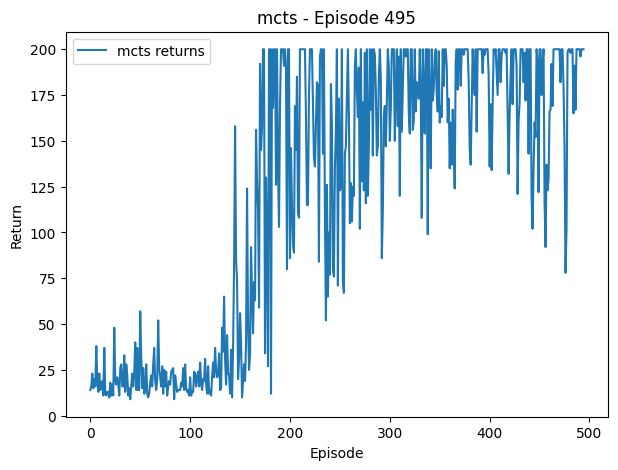

In [ ]:
search_types = ["mcts"]

for s_type in search_types:
    returns = train_with_search_policy(s_type)
    all_results[s_type] = returns

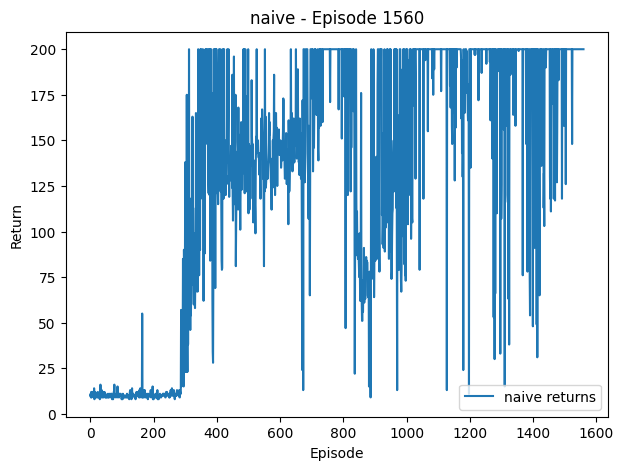

KeyboardInterrupt: 

In [ ]:
search_types = ["naive"]

for s_type in search_types:
    returns = train_with_search_policy(s_type)
    all_results[s_type] = returns


In [ ]:
search_types = ["none"]

for s_type in search_types:
    returns = train_with_search_policy(s_type)
    all_results[s_type] = returns
